### Import Required Libraries

In [84]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed, GRU
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

### Read Data

Our data is a text file of English-German sentence pairs. First we will read the file using the function defined below.

In [2]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

Now let's define a function to split the text into English-German pairs separated by '\n' and then split these pairs into English sentences and German sentences.

In [3]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

__Download the data from [here.](http://www.manythings.org/anki/deu-eng.zip)__ and extract "deu.txt" in your working directory.

In [4]:
data = read_text("deu-eng/deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

The actual data contains over 150,000 sentence-pairs. However, we will use the first 50,000 sentence pairs only to reduce the training time of the model. You can change this number as per you system computation power.

In [5]:
deu_eng = deu_eng[:50000,:]

### Text Pre-Processing

#### Text Cleaning

Let's take a look at our data, then we will decide which pre-processing steps to adopt.

In [6]:
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['You need not go there.', 'Du musst nicht dorthin gehen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #70007 (CM) & #1813634 (Pfirsichbaeumchen)'],
       ['You need not go there.', 'Du brauchst nicht dorthin zu gehen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #70007 (CM) & #1813635 (Pfirsichbaeumchen)'],
       ['You need to apologize.', 'Du musst dich entschuldigen.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3826573 (CK) & #3928528 (Tamy)']],
      dtype='<U537')

We will get rid of the punctuation marks, and then convert the text to lower case.

In [7]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [8]:
deu_eng

array([['Go', 'Geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['You need not go there', 'Du musst nicht dorthin gehen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #70007 (CM) & #1813634 (Pfirsichbaeumchen)'],
       ['You need not go there', 'Du brauchst nicht dorthin zu gehen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #70007 (CM) & #1813635 (Pfirsichbaeumchen)'],
       ['You need to apologize', 'Du musst dich entschuldigen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3826573 (CK) & #3928528 (Tamy)']],
      dtype='<U537')

In [9]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    
    deu_eng[i,1] = deu_eng[i,1].lower()

In [10]:
deu_eng

array([['go', 'geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['hi', 'hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['hi', 'grüß gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['you need not go there', 'du musst nicht dorthin gehen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #70007 (CM) & #1813634 (Pfirsichbaeumchen)'],
       ['you need not go there', 'du brauchst nicht dorthin zu gehen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #70007 (CM) & #1813635 (Pfirsichbaeumchen)'],
       ['you need to apologize', 'du musst dich entschuldigen',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3826573 (CK) & #3928528 (Tamy)']],
      dtype='<U537')

#### Text to Sequence Conversion

To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively.

In [11]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [12]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})
print(length_df)
print(max(length_df.eng))
print(max(length_df.deu))

       eng  deu
0        1    1
1        1    1
2        1    2
3        1    1
4        1    1
...    ...  ...
49995    4    5
49996    5    5
49997    5    5
49998    5    6
49999    4    4

[50000 rows x 2 columns]
7
15


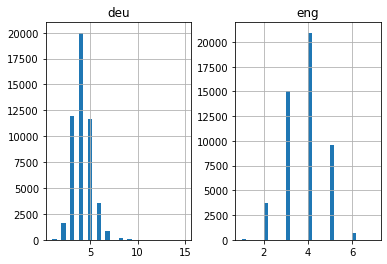

In [13]:
length_df.hist(bins = 30)
plt.show()

The maximum length of the German sentences is 11 and that of the English phrases is 8.

Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [14]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [15]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6331


In [16]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10455


Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above. 

In [17]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    print(seq)
    print(len(seq))
    return seq

# Model Building - 0

We will now split the data into train and test set for model training and evaluation, respectively.

In [18]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

It's time to encode the sentences. We will encode German sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [19]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

[[   1  109    5 ...    0    0    0]
 [   9    1 1705 ...    0    0    0]
 [   7    3   93 ...    0    0    0]
 ...
 [  11  929   23 ...    0    0    0]
 [   2   68   53 ...    0    0    0]
 [  56 4878    0 ...    0    0    0]]
40000
[[   1  356  113 ...    0    0    0]
 [  22    1  111 ...    0    0    0]
 [  23  207   69 ...    0    0    0]
 ...
 [  12 1086   40 ...    0    0    0]
 [   2   36   61 ...    0    0    0]
 [1286   68    0 ...    0    0    0]]
40000


In [20]:
print(trainX.shape)
print(trainY.shape)

(40000, 8)
(40000, 8)


In [21]:
# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

[[   1 2074   27 ...    0    0    0]
 [  11    3 2921 ...    0    0    0]
 [   2   55 3669 ...    0    0    0]
 ...
 [1021    4   56 ...    0    0    0]
 [   5   81    3 ...    0    0    0]
 [  21 1030   18 ...    0    0    0]]
10000
[[   1 2663   58 ...    0    0    0]
 [  12    4    5 ...    0    0    0]
 [   2   24 2845 ...    0    0    0]
 ...
 [  68  543   34 ...    0    0    0]
 [   7   81    4 ...    0    0    0]
 [   3  142    9 ...    0    0    0]]
10000


In [22]:
print(testX.shape)
print(testY.shape)

(10000, 8)
(10000, 8)


Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.  

In [23]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True)) #mask_zero es para rellenar con padding si la longitud de la entrada es variable
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

Details about the RepeatVector :  https://campus.datacamp.com/courses/machine-translation-in-python/implementing-an-encoder-decoder-model-with-keras?ex=6

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [24]:
print(deu_vocab_size)
print(eng_vocab_size)
print(deu_length)
print(eng_length)

10455
6331
8
8


In [25]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

Please note that we have used __'sparse_categorical_crossentropy'__ as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss. I personally prefer this method over early stopping.

In [27]:
filename = 'model_0.h1'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

C:\Users\Victor\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 107s 3ms/step - loss: 3.4520 - val_loss: 2.9028

Epoch 00001: val_loss improved from inf to 2.90284, saving model to mode_lstm_1.h1
Epoch 2/30
32000/32000 [==============================] - 103s 3ms/step - loss: 2.8102 - val_loss: 2.7676

Epoch 00002: val_loss improved from 2.90284 to 2.76764, saving model to mode_lstm_1.h1
Epoch 3/30
32000/32000 [==============================] - 105s 3ms/step - loss: 2.6571 - val_loss: 2.6106

Epoch 00003: val_loss improved from 2.76764 to 2.61058, saving model to mode_lstm_1.h1
Epoch 4/30
32000/32000 [==============================] - 103s 3ms/step - loss: 2.4632 - val_loss: 2.4692

Epoch 00004: val_loss improved from 2.61058 to 2.46921, saving model to mode_lstm_1.h1
Epoch 5/30
32000/32000 [==============================] - 105s 3ms/step - loss: 2.3168 - val_loss: 2.3550

Epoch 00005: val_loss improved from 2.46921 to 2.35498, saving model to 

Let's compare the training loss and the validation loss.

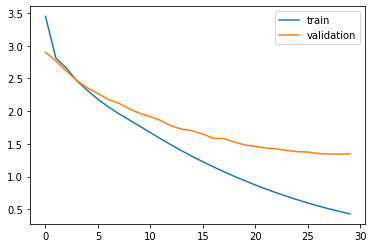

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [26]:
model = load_model('model_0.h1')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

C:\Users\Victor\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [27]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [28]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [29]:
predicted_model_0_df = pd.DataFrame({'actual' : test[:,0], 'predicted_model_0' : preds_text})
results_df = predicted_model_0_df

In [30]:
pd.set_option('display.max_colwidth', 200)

In [31]:
predicted_model_0_df.head(15)

,actual,predicted_model_0
0,tom banged his head,tom lost his bird
1,he is a dj,he is a
2,i like seafood,i like movies
3,do it tomorrow,say it
4,do you need the phone,do you need the phone
5,this door wont shut,the door open
6,i think youre stupid,i think youre be
7,toms wife just died,toms man has
8,tom kept winning,tom wore his
9,who do you live with,whats are you for


In [32]:
predicted_model_0_df.tail(15)

,actual,predicted_model_0
9985,we should be fine,we should be
9986,i had a bad cold,i had a bad cold
9987,that might be true,that might be true
9988,i dont sleep a lot,i dont like much
9989,the price is good,the ones is
9990,come back tomorrow,come again tomorrow
9991,superman can fly,can need
9992,go find out,go and see out
9993,your feet are dirty,your feet are dirty
9994,tom is immobile,tom is breathing


In [33]:
predicted_model_0_df.sample(15)

,actual,predicted_model_0
2595,tom will continue,tom will come
9431,mary giggled,mary was
6393,tom is irresponsible,tom is belligerent
361,you should be proud,you should be hard
3657,tom isnt that stupid,tom isnt just simple
8284,whats in this box,whats in this book
8426,tom wants vengeance,tom wants revenge
7139,i like lettuce,i like
6333,hes too old,its too old
6429,times are tough,the are died


# With GRU and SimpleRNN - 1

In [85]:
from keras import layers

in_vocab = deu_vocab_size
out_vocab = eng_vocab_size
in_timesteps = deu_length
out_timesteps = eng_length
units = 512
    
model = Sequential()

model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True)) #mask_zero es para rellenar con padding si la longitud de la entrada es variable

model.add(GRU(512, return_sequences=True))

model.add(layers.SimpleRNN(256, return_sequences=True))

model.add(Dense(out_vocab, activation='softmax'))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 8, 512)            5352960   
_________________________________________________________________
gru_1 (GRU)                  (None, 8, 512)            1574400   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 8, 256)            196864    
_________________________________________________________________
dense_6 (Dense)              (None, 8, 6331)           1627067   
Total params: 8,751,291
Trainable params: 8,751,291
Non-trainable params: 0
_________________________________________________________________


In [ ]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

Please note that we have used __'sparse_categorical_crossentropy'__ as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss. I personally prefer this method over early stopping.

In [ ]:
filename = 'model_gru_1.h1'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Let's compare the training loss and the validation loss.

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [34]:
model = load_model('model_gru_1.h1')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

C:\Users\Victor\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [35]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [36]:
predicted_model_gru_1_df = pd.DataFrame({'predicted_model_gru_1' : preds_text})
results_df = results_df.join(predicted_model_gru_1_df)

In [37]:
pd.set_option('display.max_colwidth', 200)

In [38]:
results_df.head(15)

,actual,predicted_model_0,predicted_model_gru_1
0,tom banged his head,tom lost his bird,tom brushed his hair
1,he is a dj,he is a,he is dj
2,i like seafood,i like movies,i like skating
3,do it tomorrow,say it,take tomorrow
4,do you need the phone,do you need the phone,do you need the
5,this door wont shut,the door open,this door is open
6,i think youre stupid,i think youre be,i think he be
7,toms wife just died,toms man has,toms wife is gone
8,tom kept winning,tom wore his,tom won singing
9,who do you live with,whats are you for,who do you talk


In [39]:
results_df.tail(15)

,actual,predicted_model_0,predicted_model_gru_1
9985,we should be fine,we should be,we should be fine
9986,i had a bad cold,i had a bad cold,i was a bad cold
9987,that might be true,that might be true,thats could be
9988,i dont sleep a lot,i dont like much,i dont sleep much
9989,the price is good,the ones is,the price is
9990,come back tomorrow,come again tomorrow,come tomorrow
9991,superman can fly,can need,dont can
9992,go find out,go and see out,is and do it
9993,your feet are dirty,your feet are dirty,her feet are dirty
9994,tom is immobile,tom is breathing,tom is hated


In [40]:
results_df.sample(15)

,actual,predicted_model_0,predicted_model_gru_1
5706,it was a blow to us,it was a rock,thats was a wait for
3918,well be seeing you,well see you,we see you
5466,i am all ears,im all ears,i a all
9140,why should i lie,why would i lie,why would i ask
8974,are you sleeping tom,are you tom,are you help
465,dont argue with tom,only with tom,go with tom
2225,do you like cooking,do you like to cook,do you like
6331,he broke into a house,he in a,he broke the a house
8353,tom is the leader,tom is as the energy,tom is the my
3377,would you care to try,you make me a,you make it on


# Otro intento  LSTM - 2

In [ ]:
from keras import layers

in_vocab = deu_vocab_size
out_vocab = eng_vocab_size
in_timesteps = deu_length
out_timesteps = eng_length
units = 512
    
model = Sequential()

model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True)) #mask_zero es para rellenar con padding si la longitud de la entrada es variable

model.add(LSTM(512, return_sequences=True))
model.add(LSTM(512, return_sequences=True))

model.add(layers.Dropout(0.5))
model.add(TimeDistributed(Dense(out_vocab)))
model.add(layers.Activation('softmax'))

model.summary()

In [ ]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

Please note that we have used __'sparse_categorical_crossentropy'__ as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss. I personally prefer this method over early stopping.

In [ ]:
filename = 'model_2.h1'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Let's compare the training loss and the validation loss.

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [41]:
model = load_model('model_2.h1')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

C:\Users\Victor\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [42]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [43]:
predicted_model_2_df = pd.DataFrame({'predicted_model_2' : preds_text})
results_df = results_df.join(predicted_model_2_df)

In [44]:
pd.set_option('display.max_colwidth', 200)

In [45]:
results_df.head(15)

,actual,predicted_model_0,predicted_model_gru_1,predicted_model_2
0,tom banged his head,tom lost his bird,tom brushed his hair,tom lowered his head
1,he is a dj,he is a,he is dj,he is overweight
2,i like seafood,i like movies,i like skating,i like snow
3,do it tomorrow,say it,take tomorrow,do tomorrow
4,do you need the phone,do you need the phone,do you need the,do you need the
5,this door wont shut,the door open,this door is open,this door is open
6,i think youre stupid,i think youre be,i think he be,i think tom right
7,toms wife just died,toms man has,toms wife is gone,toms wife is
8,tom kept winning,tom wore his,tom won singing,tom won more
9,who do you live with,whats are you for,who do you talk,who are you talk


In [46]:
results_df.tail(15)

,actual,predicted_model_0,predicted_model_gru_1,predicted_model_2
9985,we should be fine,we should be,we should be fine,we should go fine
9986,i had a bad cold,i had a bad cold,i was a bad cold,i had a bad cold
9987,that might be true,that might be true,thats could be,this could be
9988,i dont sleep a lot,i dont like much,i dont sleep much,i like sleep much
9989,the price is good,the ones is,the price is,the price is good
9990,come back tomorrow,come again tomorrow,come tomorrow,come tomorrow
9991,superman can fly,can need,dont can,dont can fly
9992,go find out,go and see out,is and do it,is and me
9993,your feet are dirty,your feet are dirty,her feet are dirty,your feet are dirty
9994,tom is immobile,tom is breathing,tom is hated,tom is mortified


In [47]:
results_df.sample(15)

,actual,predicted_model_0,predicted_model_gru_1,predicted_model_2
1490,i apologize for that,ill agree to,i dont to for,i get to for
2673,we have to act fast,we must an quickly,we must work quickly,we must be quickly
6617,tom threatened mary,tom ignored mary,tom has mary,tom has mary
1099,i want the fan,i want my mommy my,i want to the,i want to the
33,tom continued talking,tom kept talking,tom spoke singing,tom spoke
5887,they voted,they have problems,she lost,she have
3885,how about a song,how about this make,how about it,how about it
1580,tom is a chatterbox,tom is a veteran,tom is a,tom is a honest
8391,i knew it was a joke,i knew that was a,i knew youd all a joke,i knew youd was a joke
4516,have you ever lost,did you say a,did you have a lot,did you get the


# Otro intento  - 3

In [62]:
from keras import layers

in_vocab = deu_vocab_size
out_vocab = eng_vocab_size
in_timesteps = deu_length
out_timesteps = eng_length
units = 512
    
model = Sequential()

model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True)) #mask_zero es para rellenar con padding si la longitud de la entrada es variable
model.add(TimeDistributed(Dense(out_vocab)))

model.add(LSTM(units, return_sequences=True))
model.add(layers.Dropout(0.4))

model.add(TimeDistributed(Dense(out_vocab)))
model.add(layers.Activation('softmax'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 8, 512)            5352960   
_________________________________________________________________
time_distributed_6 (TimeDist (None, 8, 6331)           3247803   
_________________________________________________________________
lstm_5 (LSTM)                (None, 8, 512)            14016512  
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 512)            0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 8, 6331)           3247803   
_________________________________________________________________
activation_3 (Activation)    (None, 8, 6331)           0         
Total params: 25,865,078
Trainable params: 25,865,078
Non-trainable params: 0
__________________________________________

In [63]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

Please note that we have used __'sparse_categorical_crossentropy'__ as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss. I personally prefer this method over early stopping.

In [64]:
filename = 'model_3.h1'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

C:\Users\Victor\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 181s 6ms/step - loss: 2.4962 - val_loss: 2.1087

Epoch 00001: val_loss improved from inf to 2.10867, saving model to model_3.h1
Epoch 2/30
32000/32000 [==============================] - 187s 6ms/step - loss: 1.9511 - val_loss: 1.8877

Epoch 00002: val_loss improved from 2.10867 to 1.88769, saving model to model_3.h1
Epoch 3/30
32000/32000 [==============================] - 189s 6ms/step - loss: 1.7270 - val_loss: 1.7684

Epoch 00003: val_loss improved from 1.88769 to 1.76841, saving model to model_3.h1
Epoch 4/30
32000/32000 [==============================] - 179s 6ms/step - loss: 1.5677 - val_loss: 1.6488

Epoch 00004: val_loss improved from 1.76841 to 1.64877, saving model to model_3.h1
Epoch 5/30
32000/32000 [==============================] - 182s 6ms/step - loss: 1.4449 - val_loss: 1.5759

Epoch 00005: val_loss improved from 1.64877 to 1.57595, saving model to model_3.h1
Epoch

Let's compare the training loss and the validation loss.

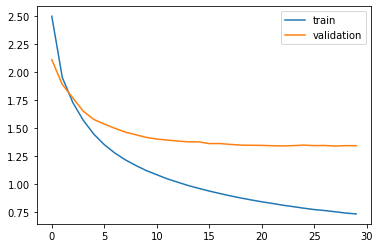

In [65]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [48]:
model = load_model('model_3.h1')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

C:\Users\Victor\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [49]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [50]:
predicted_model_3_df = pd.DataFrame({'predicted_model_3' : preds_text})
results_df = results_df.join(predicted_model_3_df)

In [51]:
pd.set_option('display.max_colwidth', 200)

In [52]:
results_df.head(15)

,actual,predicted_model_0,predicted_model_gru_1,predicted_model_2,predicted_model_3
0,tom banged his head,tom lost his bird,tom brushed his hair,tom lowered his head,tom pushed his head
1,he is a dj,he is a,he is dj,he is overweight,he is dj
2,i like seafood,i like movies,i like skating,i like snow,i like sweets
3,do it tomorrow,say it,take tomorrow,do tomorrow,take tomorrow
4,do you need the phone,do you need the phone,do you need the,do you need the,do you need the
5,this door wont shut,the door open,this door is open,this door is open,this door is open
6,i think youre stupid,i think youre be,i think he be,i think tom right,i think tom like
7,toms wife just died,toms man has,toms wife is gone,toms wife is,toms wife is just
8,tom kept winning,tom wore his,tom won singing,tom won more,tom won on
9,who do you live with,whats are you for,who do you talk,who are you talk,who did do you together


In [53]:
results_df.tail(15)

,actual,predicted_model_0,predicted_model_gru_1,predicted_model_2,predicted_model_3
9985,we should be fine,we should be,we should be fine,we should go fine,we should be fine
9986,i had a bad cold,i had a bad cold,i was a bad cold,i had a bad cold,i had a bad cold
9987,that might be true,that might be true,thats could be,this could be,this could be
9988,i dont sleep a lot,i dont like much,i dont sleep much,i like sleep much,i not sleep much
9989,the price is good,the ones is,the price is,the price is good,the price is good
9990,come back tomorrow,come again tomorrow,come tomorrow,come tomorrow,come and tomorrow
9991,superman can fly,can need,dont can,dont can fly,dont can fly
9992,go find out,go and see out,is and do it,is and me,is and do it
9993,your feet are dirty,your feet are dirty,her feet are dirty,your feet are dirty,your feet are dirty
9994,tom is immobile,tom is breathing,tom is hated,tom is mortified,tom is understand


In [54]:
results_df.sample(15)

,actual,predicted_model_0,predicted_model_gru_1,predicted_model_2,predicted_model_3
1463,he is at her side,hes is side,he is the side,he is up side,he is on side
3739,i miss it,that me,it lacks confidence,it lacks,it missing imagination
8607,it was really cheap,it was very close,it was very hard,it was very funny,it was very quiet
5812,take precautions,a,dont up,dont your,dont it
5900,were certain,were safe,we are,we not,we are in
7291,what happened,what happened,what is,what is,what is
5719,three weeks went by,many the three on,three weeks dry,three skin higher,three weeks save
8473,you bet im angry,am i look in,and does i like me,and tom im me,and it i
459,tom often goes there,tom may here,tom is go there,tom is running here,tom is go there
1198,they were attacked,they were brave,she were attack,she were younger,she were attacked


# Otro intento  - 4

In [68]:
from keras import layers

in_vocab = deu_vocab_size
out_vocab = eng_vocab_size
in_timesteps = deu_length
out_timesteps = eng_length
units = 128
    
model = Sequential()

model.add(Embedding(in_vocab, out_vocab, input_length=in_timesteps, mask_zero=True)) #mask_zero es para rellenar con padding si la longitud de la entrada es variable

model.add(LSTM(units))
model.add(RepeatVector(out_timesteps))

model.add(LSTM(units, return_sequences=True))
model.add(TimeDistributed(Dense(out_vocab)))
model.add(layers.Activation('softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 8, 6331)           66190605  
_________________________________________________________________
lstm_9 (LSTM)                (None, 128)               3307520   
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 8, 128)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 8, 128)            131584    
_________________________________________________________________
time_distributed_4 (TimeDist (None, 8, 6331)           816699    
_________________________________________________________________
activation_3 (Activation)    (None, 8, 6331)           0         
Total params: 70,446,408
Trainable params: 70,446,408
Non-trainable params: 0
__________________________________________

In [71]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [72]:
filename = 'model_4.h1'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=256, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

C:\Users\Victor\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 177s 6ms/step - loss: 4.2907 - val_loss: 3.4993

Epoch 00001: val_loss improved from inf to 3.49925, saving model to model_4.h1
Epoch 2/30
32000/32000 [==============================] - 169s 5ms/step - loss: 3.3280 - val_loss: 3.1725

Epoch 00002: val_loss improved from 3.49925 to 3.17247, saving model to model_4.h1
Epoch 3/30
32000/32000 [==============================] - 171s 5ms/step - loss: 3.0341 - val_loss: 2.9808

Epoch 00003: val_loss improved from 3.17247 to 2.98084, saving model to model_4.h1
Epoch 4/30
32000/32000 [==============================] - 191s 6ms/step - loss: 2.8868 - val_loss: 2.8831

Epoch 00004: val_loss improved from 2.98084 to 2.88306, saving model to model_4.h1
Epoch 5/30
32000/32000 [==============================] - 189s 6ms/step - loss: 2.8127 - val_loss: 2.8444

Epoch 00005: val_loss improved from 2.88306 to 2.84443, saving model to model_4.h1
Epoch

Let's compare the training loss and the validation loss.

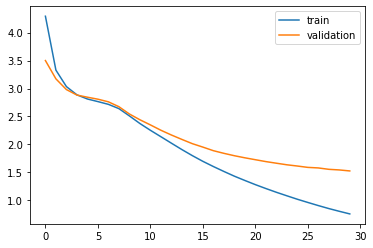

In [73]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [74]:
model = load_model('model_4.h1')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

C:\Users\Victor\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [76]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [77]:
predicted_model_4_df = pd.DataFrame({'predicted_model_4' : preds_text})
results_df = results_df.join(predicted_model_4_df)

In [78]:
pd.set_option('display.max_colwidth', 200)

In [79]:
results_df.head(15)

,actual,predicted_model_0,predicted_model_gru_1,predicted_model_2,predicted_model_3,predicted_model_4
0,tom banged his head,tom lost his bird,tom brushed his hair,tom lowered his head,tom pushed his head,tom raised his
1,he is a dj,he is a,he is dj,he is overweight,he is dj,he is a
2,i like seafood,i like movies,i like skating,i like snow,i like sweets,i like
3,do it tomorrow,say it,take tomorrow,do tomorrow,take tomorrow,change again
4,do you need the phone,do you need the phone,do you need the,do you need the,do you need the,do you use the phone
5,this door wont shut,the door open,this door is open,this door is open,this door is open,this isnt open
6,i think youre stupid,i think youre be,i think he be,i think tom right,i think tom like,i think youre drunk
7,toms wife just died,toms man has,toms wife is gone,toms wife is,toms wife is just,toms is
8,tom kept winning,tom wore his,tom won singing,tom won more,tom won on,tom kept the night
9,who do you live with,whats are you for,who do you talk,who are you talk,who did do you together,who will you with


In [80]:
results_df.tail(15)

,actual,predicted_model_0,predicted_model_gru_1,predicted_model_2,predicted_model_3,predicted_model_4
9985,we should be fine,we should be,we should be fine,we should go fine,we should be fine,we be well
9986,i had a bad cold,i had a bad cold,i was a bad cold,i had a bad cold,i had a bad cold,i was a cold
9987,that might be true,that might be true,thats could be,this could be,this could be,it was be true
9988,i dont sleep a lot,i dont like much,i dont sleep much,i like sleep much,i not sleep much,i dont a
9989,the price is good,the ones is,the price is,the price is good,the price is good,the good is good
9990,come back tomorrow,come again tomorrow,come tomorrow,come tomorrow,come and tomorrow,come tomorrow
9991,superman can fly,can need,dont can,dont can fly,dont can fly,can fly
9992,go find out,go and see out,is and do it,is and me,is and do it,come out
9993,your feet are dirty,your feet are dirty,her feet are dirty,your feet are dirty,your feet are dirty,my feet are dirty
9994,tom is immobile,tom is breathing,tom is hated,tom is mortified,tom is understand,tom is


In [81]:
results_df.sample(15)

,actual,predicted_model_0,predicted_model_gru_1,predicted_model_2,predicted_model_3,predicted_model_4
8297,i should go home,i should go,i should go,i should go,i should go,i should go
3327,i wish i had known,i wish i had seen,i wish i had that,i wish i had that,i wish i had this,i know i said that
1659,i knew youd be here,i knew were,i knew youd were here,i knew youd were here,i knew youd like here,i know youre here
3035,we studied english,we have english,we learned english,we learned english,we learned english,we drank english
4624,he is about thirty,hes is and,he is about thirty,he is about at,he is about thirty,hes is from
104,its time for lunch,its lunch time,it a to,it a,it is time,its time
5737,add some salt,give a by,please something,give something some,give something salt,give a hard
1602,whats in that bottle,whats in the bottle,what is the bag,what is the,what is the box,whats in the
7493,shes been poisoned,she was stolen,she became beaten,she was killed,she became born,she was
9462,i dont like to clean,i dont like to,i on work,i fell on to,i am up,i dont like


# Otro intento  - 5

In [252]:
from keras import layers
from keras.optimizers import Adam
import tensorflow as tf
from tensorflow import keras

in_vocab = deu_vocab_size
out_vocab = eng_vocab_size
in_timesteps = deu_length
out_timesteps = eng_length
units = 128
learning_rate = 0.005
          
model = Sequential()
model.add(layers.Reshape((trainX.shape[1], 1), input_shape=(trainX.shape[1], )))
model.add(GRU(256, input_shape=(out_vocab,), return_sequences=True))
model.add(TimeDistributed(Dense(1024, activation='relu')))
model.add(layers.Dropout(0.5))
model.add(TimeDistributed(Dense(out_vocab, activation='softmax'))) 

model.summary()

Model: "sequential_92"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_36 (Reshape)         (None, 8, 1)              0         
_________________________________________________________________
gru_30 (GRU)                 (None, 8, 256)            198144    
_________________________________________________________________
time_distributed_41 (TimeDis (None, 8, 1024)           263168    
_________________________________________________________________
dropout_19 (Dropout)         (None, 8, 1024)           0         
_________________________________________________________________
time_distributed_42 (TimeDis (None, 8, 6331)           6489275   
Total params: 6,950,587
Trainable params: 6,950,587
Non-trainable params: 0
_________________________________________________________________


In [253]:
#rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [254]:
filename = 'model_5.h1'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=1024, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 72s 2ms/step - loss: 3.8151 - accuracy: 0.5150 - val_loss: 3.0085 - val_accuracy: 0.5477

Epoch 00001: val_loss improved from inf to 3.00847, saving model to model_5.h1
Epoch 2/30
32000/32000 [==============================] - 67s 2ms/step - loss: 2.8542 - accuracy: 0.5606 - val_loss: 2.7318 - val_accuracy: 0.5894

Epoch 00002: val_loss improved from 3.00847 to 2.73178, saving model to model_5.h1
Epoch 3/30
32000/32000 [==============================] - 68s 2ms/step - loss: 2.6643 - accuracy: 0.5919 - val_loss: 2.6094 - val_accuracy: 0.5993

Epoch 00003: val_loss improved from 2.73178 to 2.60935, saving model to model_5.h1
Epoch 4/30
32000/32000 [==============================] - 67s 2ms/step - loss: 2.5713 - accuracy: 0.6007 - val_loss: 2.5447 - val_accuracy: 0.6029

Epoch 00004: val_loss improved from 2.60935 to 2.54471, saving model to model_5.h1
Epoch 5/30
32000/32000 [=======

Let's compare the training loss and the validation loss.

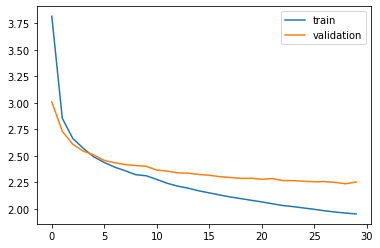

In [255]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [256]:
model = load_model('model_5.h1')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [257]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [258]:
predicted_model_5_df = pd.DataFrame({'predicted_model_5' : preds_text})
results_df = results_df.join(predicted_model_5_df)

In [259]:
pd.set_option('display.max_colwidth', 200)

In [260]:
results_df.head(15)

,actual,predicted_model_0,predicted_model_gru_1,predicted_model_2,predicted_model_3,predicted_model_4,predicted_model_5
0,tom banged his head,tom lost his bird,tom brushed his hair,tom lowered his head,tom pushed his head,tom raised his,tom is a
1,he is a dj,he is a,he is dj,he is overweight,he is dj,he is a,he is
2,i like seafood,i like movies,i like skating,i like snow,i like sweets,i like,i want to
3,do it tomorrow,say it,take tomorrow,do tomorrow,take tomorrow,change again,dont your
4,do you need the phone,do you need the phone,do you need the,do you need the,do you need the,do you use the phone,dont you it
5,this door wont shut,the door open,this door is open,this door is open,this door is open,this isnt open,come book
6,i think youre stupid,i think youre be,i think he be,i think tom right,i think tom like,i think youre drunk,i think you
7,toms wife just died,toms man has,toms wife is gone,toms wife is,toms wife is just,toms is,lets would is
8,tom kept winning,tom wore his,tom won singing,tom won more,tom won on,tom kept the night,tom is his
9,who do you live with,whats are you for,who do you talk,who are you talk,who did do you together,who will you with,my are is you


In [261]:
results_df.tail(15)

,actual,predicted_model_0,predicted_model_gru_1,predicted_model_2,predicted_model_3,predicted_model_4,predicted_model_5
9985,we should be fine,we should be,we should be fine,we should go fine,we should be fine,we be well,we know to
9986,i had a bad cold,i had a bad cold,i was a bad cold,i had a bad cold,i had a bad cold,i was a cold,i need to
9987,that might be true,that might be true,thats could be,this could be,this could be,it was be true,this must
9988,i dont sleep a lot,i dont like much,i dont sleep much,i like sleep much,i not sleep much,i dont a,i dont it
9989,the price is good,the ones is,the price is,the price is good,the price is good,the good is good,how is
9990,come back tomorrow,come again tomorrow,come tomorrow,come tomorrow,come and tomorrow,come tomorrow,lets you
9991,superman can fly,can need,dont can,dont can fly,dont can fly,can fly,dont you
9992,go find out,go and see out,is and do it,is and me,is and do it,come out,please book is you
9993,your feet are dirty,your feet are dirty,her feet are dirty,your feet are dirty,your feet are dirty,my feet are dirty,when is me
9994,tom is immobile,tom is breathing,tom is hated,tom is mortified,tom is understand,tom is,tom is a


In [262]:
results_df.sample(15)

,actual,predicted_model_0,predicted_model_gru_1,predicted_model_2,predicted_model_3,predicted_model_4,predicted_model_5
1238,did you know that,did you know that,did you mean this,did you read this,do you mean this,did you know that,my you it
9243,its a plant,its a steal tree,thats is a,this is a,this is a,thats a,this is a
6140,leave it there,stop it there,let it there,let it there,let it there,lets it there,lets you
8439,thats toms sister,thats is toms sister,thats is toms,this is toms,this is toms,thats toms sister,this is a
202,give me another one,give me another one,give me to one,give me to one,give me the beer,give me another one,do you me
666,everyone dreams,everybody is swimming,everyone tom,everybody is,everyone loves,everyone dreams,do your
313,is tom coming with us,is tom with,come tom with,come tom with us,come tom with,is tom with us,when tom go you
9506,no one saw me,nobody saw me,nobody one me,nobody one me,nobody one me,nobody one me,please you me
2764,i have cancer,i have cancer,i have cancer,i have cancer,i have cancer,i have cancer,i have
8004,its too late now,its too late,now is,now is now,now is now,its too late,please is it


# Otro intento  - 6

In [263]:
from keras import layers

in_vocab = deu_vocab_size
out_vocab = eng_vocab_size
in_timesteps = deu_length
out_timesteps = eng_length
units = 256
learning_rate = 0.005

# Build the layers    
model = Sequential()
# Embedding
model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
# Encoder
model.add(LSTM(units, return_sequences=True))
model.add(layers.Dropout(0.5))
model.add(TimeDistributed(Dense(out_vocab, activation='softmax')))

model.summary()

Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 8, 256)            2676480   
_________________________________________________________________
lstm_68 (LSTM)               (None, 8, 256)            525312    
_________________________________________________________________
dropout_20 (Dropout)         (None, 8, 256)            0         
_________________________________________________________________
time_distributed_43 (TimeDis (None, 8, 6331)           1627067   
Total params: 4,828,859
Trainable params: 4,828,859
Non-trainable params: 0
_________________________________________________________________


In [264]:
#rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=Adam(learning_rate), loss='sparse_categorical_crossentropy')

In [265]:
filename = 'model_6.h1'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=1024, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

C:\Users\Victor\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 47s 1ms/step - loss: 3.4594 - val_loss: 2.6466

Epoch 00001: val_loss improved from inf to 2.64661, saving model to model_6.h1
Epoch 2/30
32000/32000 [==============================] - 48s 1ms/step - loss: 2.4779 - val_loss: 2.3270

Epoch 00002: val_loss improved from 2.64661 to 2.32704, saving model to model_6.h1
Epoch 3/30
32000/32000 [==============================] - 64s 2ms/step - loss: 2.2041 - val_loss: 2.1168

Epoch 00003: val_loss improved from 2.32704 to 2.11682, saving model to model_6.h1
Epoch 4/30
32000/32000 [==============================] - 65s 2ms/step - loss: 1.9946 - val_loss: 1.9599

Epoch 00004: val_loss improved from 2.11682 to 1.95986, saving model to model_6.h1
Epoch 5/30
32000/32000 [==============================] - 62s 2ms/step - loss: 1.8306 - val_loss: 1.8440

Epoch 00005: val_loss improved from 1.95986 to 1.84396, saving model to model_6.h1
Epoch 6/30

Let's compare the training loss and the validation loss.

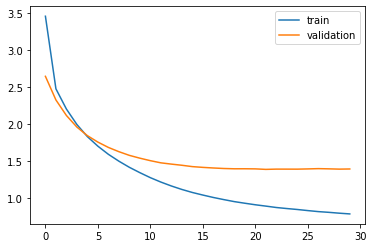

In [266]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [267]:
model = load_model('model_6.h1')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

C:\Users\Victor\anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [268]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [269]:
predicted_model_6_df = pd.DataFrame({'predicted_model_6' : preds_text})
results_df = results_df.join(predicted_model_6_df)

In [270]:
pd.set_option('display.max_colwidth', 200)

In [271]:
results_df.head(15)

,actual,predicted_model_0,predicted_model_gru_1,predicted_model_2,predicted_model_3,predicted_model_4,predicted_model_5,predicted_model_6
0,tom banged his head,tom lost his bird,tom brushed his hair,tom lowered his head,tom pushed his head,tom raised his,tom is a,tom pushed his
1,he is a dj,he is a,he is dj,he is overweight,he is dj,he is a,he is,he is dj
2,i like seafood,i like movies,i like skating,i like snow,i like sweets,i like,i want to,i like
3,do it tomorrow,say it,take tomorrow,do tomorrow,take tomorrow,change again,dont your,do tomorrow
4,do you need the phone,do you need the phone,do you need the,do you need the,do you need the,do you use the phone,dont you it,do you need the
5,this door wont shut,the door open,this door is open,this door is open,this door is open,this isnt open,come book,this door is open
6,i think youre stupid,i think youre be,i think he be,i think tom right,i think tom like,i think youre drunk,i think you,i think i like stupid
7,toms wife just died,toms man has,toms wife is gone,toms wife is,toms wife is just,toms is,lets would is,toms wife is
8,tom kept winning,tom wore his,tom won singing,tom won more,tom won on,tom kept the night,tom is his,tom won on
9,who do you live with,whats are you for,who do you talk,who are you talk,who did do you together,who will you with,my are is you,who did do


In [272]:
results_df.tail(15)

,actual,predicted_model_0,predicted_model_gru_1,predicted_model_2,predicted_model_3,predicted_model_4,predicted_model_5,predicted_model_6
9985,we should be fine,we should be,we should be fine,we should go fine,we should be fine,we be well,we know to,we should go fine
9986,i had a bad cold,i had a bad cold,i was a bad cold,i had a bad cold,i had a bad cold,i was a cold,i need to,i had a bad cold
9987,that might be true,that might be true,thats could be,this could be,this could be,it was be true,this must,thats could be
9988,i dont sleep a lot,i dont like much,i dont sleep much,i like sleep much,i not sleep much,i dont a,i dont it,i dont sleeping much
9989,the price is good,the ones is,the price is,the price is good,the price is good,the good is good,how is,the price is good
9990,come back tomorrow,come again tomorrow,come tomorrow,come tomorrow,come and tomorrow,come tomorrow,lets you,come tomorrow
9991,superman can fly,can need,dont can,dont can fly,dont can fly,can fly,dont you,puzzles can
9992,go find out,go and see out,is and do it,is and me,is and do it,come out,please book is you,is and you it
9993,your feet are dirty,your feet are dirty,her feet are dirty,your feet are dirty,your feet are dirty,my feet are dirty,when is me,her feet are dirty
9994,tom is immobile,tom is breathing,tom is hated,tom is mortified,tom is understand,tom is,tom is a,tom is rigid


In [273]:
results_df.sample(15)

,actual,predicted_model_0,predicted_model_gru_1,predicted_model_2,predicted_model_3,predicted_model_4,predicted_model_5,predicted_model_6
6738,toms concerned,tom is troubled,tom is alarmed,tom is alarmed,tom is alarmed,tom is worried,tom is a,tom is troubled
7136,tom doesnt mind,tom isnt doing that,tom is that,tom is that,tom is doing do,tom is not that,tom looks it that,tom is that
3238,dont let the dog out,dont the dog out,let me the,let me the,let me the dog,dont be the dog,do you,let me the dog
378,who are you all,who are you,who are you,who are you,who are you,who are you,why did you,who are you
6402,check please,the bill please,the bill please,the bill please,the bill please,the bill please,you is you,the bill please
7018,let tom go,let tom go,lets tom come,lets tom go,lets tom leave,let tom go,do tom,lets tom go
2767,it was an accident,it was an accident,it was a accident,it was a accident,it was a accident,it was an accident,its was a,it was a accident
9386,exercise every day,keep a,keep what,keep yourself,keep every,watch down,dont you,keep practicing a
4600,wheres it from,where are going,where is you,wheres tom you,where tom she,where here,why dog you,wheres is you
8431,tom wasnt safe,tom wasnt done,tom was honest,tom was very,tom was very,tom wasnt ready,tom was it,tom was honest


# Otro intento  - 7

In [274]:
from keras import layers

in_vocab = deu_vocab_size
out_vocab = eng_vocab_size
in_timesteps = deu_length
out_timesteps = eng_length
#units = 256
learning_rate = 0.005

# Build the layers    
model = Sequential()
# Embedding
model.add(layers.Reshape((trainX.shape[1], 1), input_shape=(trainX.shape[1], )))
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(out_vocab,)))
model.add(TimeDistributed(Dense(1024, activation='relu')))
model.add(layers.Dropout(0.5))
model.add(TimeDistributed(Dense(out_vocab, activation='softmax')))

model.summary()

Model: "sequential_94"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_37 (Reshape)         (None, 8, 1)              0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 8, 256)            133120    
_________________________________________________________________
time_distributed_44 (TimeDis (None, 8, 1024)           263168    
_________________________________________________________________
dropout_21 (Dropout)         (None, 8, 1024)           0         
_________________________________________________________________
time_distributed_45 (TimeDis (None, 8, 6331)           6489275   
Total params: 6,885,563
Trainable params: 6,885,563
Non-trainable params: 0
_________________________________________________________________


In [275]:
#rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=Adam(learning_rate), loss='sparse_categorical_crossentropy')

In [276]:
filename = 'model_7.h1'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=1024, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 82s 3ms/step - loss: 3.6431 - val_loss: 2.7725

Epoch 00001: val_loss improved from inf to 2.77248, saving model to model_7.h1
Epoch 2/30
32000/32000 [==============================] - 82s 3ms/step - loss: 2.6729 - val_loss: 2.5875

Epoch 00002: val_loss improved from 2.77248 to 2.58745, saving model to model_7.h1
Epoch 3/30
32000/32000 [==============================] - 81s 3ms/step - loss: 2.5189 - val_loss: 2.4819

Epoch 00003: val_loss improved from 2.58745 to 2.48195, saving model to model_7.h1
Epoch 4/30
32000/32000 [==============================] - 78s 2ms/step - loss: 2.4140 - val_loss: 2.4199

Epoch 00004: val_loss improved from 2.48195 to 2.41985, saving model to model_7.h1
Epoch 5/30
32000/32000 [==============================] - 80s 2ms/step - loss: 2.3379 - val_loss: 2.3587

Epoch 00005: val_loss improved from 2.41985 to 2.35873, saving model to model_7.h1
Epoch 6/30

Let's compare the training loss and the validation loss.

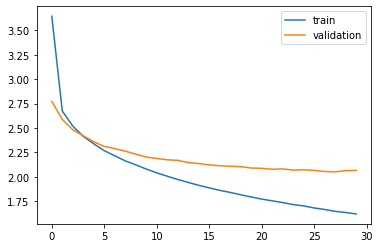

In [277]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [278]:
model = load_model('model_7.h1')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [279]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [280]:
predicted_model_7_df = pd.DataFrame({'predicted_model_7' : preds_text})
results_df = results_df.join(predicted_model_7_df)

In [281]:
pd.set_option('display.max_colwidth', 200)

In [282]:
results_df.head(15)

,actual,predicted_model_0,predicted_model_gru_1,predicted_model_2,predicted_model_3,predicted_model_4,predicted_model_5,predicted_model_6,predicted_model_7
0,tom banged his head,tom lost his bird,tom brushed his hair,tom lowered his head,tom pushed his head,tom raised his,tom is a,tom pushed his,tom hid in the
1,he is a dj,he is a,he is dj,he is overweight,he is dj,he is a,he is,he is dj,hes is
2,i like seafood,i like movies,i like skating,i like snow,i like sweets,i like,i want to,i like,i like
3,do it tomorrow,say it,take tomorrow,do tomorrow,take tomorrow,change again,dont your,do tomorrow,keep on
4,do you need the phone,do you need the phone,do you need the,do you need the,do you need the,do you use the phone,dont you it,do you need the,dont you the
5,this door wont shut,the door open,this door is open,this door is open,this door is open,this isnt open,come book,this door is open,when this dont bite
6,i think youre stupid,i think youre be,i think he be,i think tom right,i think tom like,i think youre drunk,i think you,i think i like stupid,i knew youre you
7,toms wife just died,toms man has,toms wife is gone,toms wife is,toms wife is just,toms is,lets would is,toms wife is,this cat is
8,tom kept winning,tom wore his,tom won singing,tom won more,tom won on,tom kept the night,tom is his,tom won on,tom kept mary
9,who do you live with,whats are you for,who do you talk,who are you talk,who did do you together,who will you with,my are is you,who did do,my your is you


In [283]:
results_df.tail(15)

,actual,predicted_model_0,predicted_model_gru_1,predicted_model_2,predicted_model_3,predicted_model_4,predicted_model_5,predicted_model_6,predicted_model_7
9985,we should be fine,we should be,we should be fine,we should go fine,we should be fine,we be well,we know to,we should go fine,we should your
9986,i had a bad cold,i had a bad cold,i was a bad cold,i had a bad cold,i had a bad cold,i was a cold,i need to,i had a bad cold,i need a
9987,that might be true,that might be true,thats could be,this could be,this could be,it was be true,this must,thats could be,that need
9988,i dont sleep a lot,i dont like much,i dont sleep much,i like sleep much,i not sleep much,i dont a,i dont it,i dont sleeping much,i dont do
9989,the price is good,the ones is,the price is,the price is good,the price is good,the good is good,how is,the price is good,the do is
9990,come back tomorrow,come again tomorrow,come tomorrow,come tomorrow,come and tomorrow,come tomorrow,lets you,come tomorrow,do your
9991,superman can fly,can need,dont can,dont can fly,dont can fly,can fly,dont you,puzzles can,get you
9992,go find out,go and see out,is and do it,is and me,is and do it,come out,please book is you,is and you it,please your wont
9993,your feet are dirty,your feet are dirty,her feet are dirty,your feet are dirty,your feet are dirty,my feet are dirty,when is me,her feet are dirty,this men are
9994,tom is immobile,tom is breathing,tom is hated,tom is mortified,tom is understand,tom is,tom is a,tom is rigid,tom is a


In [284]:
results_df.sample(15)

,actual,predicted_model_0,predicted_model_gru_1,predicted_model_2,predicted_model_3,predicted_model_4,predicted_model_5,predicted_model_6,predicted_model_7
3640,its a monster storm,its a,it a big,it a big,it is a,its is a girl,its is a,it a,its a
8179,may god reward you,may i in,may god bless reward,may god,may god reward dont,can you god you,dont is,may god reward the,the your reflects grass
6257,why is this,which is,what is the,what is the,what is this,what is your,dont your you,what is the,dont do this
970,tom is baking a pizza,tom is a,tom is baking a,tom is baking a,tom is baking pizza,tom a,tom is a,tom is baking pizza,tom peeled a
2287,memorize it,do it a,dont it yourself new,dont it,dont it,theyre it,dont you it,is it be a,dont you for
4899,i have money for you,i found the money,i have money for you,i have money for you,i have money for you,i am for you,i have a,i have money for you,i have of for
8202,i thought that too,i thought that so tom,thats thought know for,this already that too,this thought i that too,i know i too,this is tom a,thats thought i me too,i think i to
1880,im smarter than you,im am than you,i a you,i not you,i not smart than,im am of,i am,i not smart,im stronger than
3254,i cant give you that,i cant blame you,i cant help you that,i cant help you that,i cant help you that,i cant give that,i cant my you,i cant help you that,i cant you
5356,tom didnt talk,tom didnt listen,tom kept sing,tom kept cry,tom talked mary,tom didnt crying,tom is it,tom kept to,tom dont it


# Otro intento  - 8

In [285]:
from keras import layers

in_vocab = deu_vocab_size
out_vocab = eng_vocab_size
in_timesteps = deu_length
out_timesteps = eng_length
#units = 256
learning_rate = 0.001

# Build the layers    
model = Sequential()
# Reshape
model.add(layers.Reshape((trainX.shape[1], 1), input_shape=(trainX.shape[1], )))
# Encoder
model.add(LSTM(256, go_backwards=True, input_shape=(8, 256,)))
model.add(RepeatVector(8))
# Decoder
model.add(LSTM(256, return_sequences=True))
model.add(TimeDistributed(Dense(1024, activation='relu')))
model.add(layers.Dropout(0.5))
model.add(TimeDistributed(Dense(out_vocab, activation='softmax')))

model.summary()

Model: "sequential_95"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_38 (Reshape)         (None, 8, 1)              0         
_________________________________________________________________
lstm_70 (LSTM)               (None, 256)               264192    
_________________________________________________________________
repeat_vector_44 (RepeatVect (None, 8, 256)            0         
_________________________________________________________________
lstm_71 (LSTM)               (None, 8, 256)            525312    
_________________________________________________________________
time_distributed_46 (TimeDis (None, 8, 1024)           263168    
_________________________________________________________________
dropout_22 (Dropout)         (None, 8, 1024)           0         
_________________________________________________________________
time_distributed_47 (TimeDis (None, 8, 6331)         

In [286]:
#rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=Adam(learning_rate), loss='sparse_categorical_crossentropy')

In [287]:
filename = 'model_8.h1'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=1024, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 63s 2ms/step - loss: 4.6395 - val_loss: 3.4816

Epoch 00001: val_loss improved from inf to 3.48162, saving model to model_8.h1
Epoch 2/30
32000/32000 [==============================] - 63s 2ms/step - loss: 3.2642 - val_loss: 3.0077

Epoch 00002: val_loss improved from 3.48162 to 3.00765, saving model to model_8.h1
Epoch 3/30
32000/32000 [==============================] - 63s 2ms/step - loss: 2.9069 - val_loss: 2.8465

Epoch 00003: val_loss improved from 3.00765 to 2.84653, saving model to model_8.h1
Epoch 4/30
32000/32000 [==============================] - 63s 2ms/step - loss: 2.8060 - val_loss: 2.7810

Epoch 00004: val_loss improved from 2.84653 to 2.78097, saving model to model_8.h1
Epoch 5/30
32000/32000 [==============================] - 64s 2ms/step - loss: 2.7354 - val_loss: 2.7175

Epoch 00005: val_loss improved from 2.78097 to 2.71753, saving model to model_8.h1
Epoch 6/30

Let's compare the training loss and the validation loss.

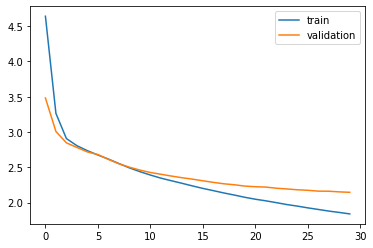

In [288]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [289]:
model = load_model('model_7.h1')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [290]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [291]:
predicted_model_8_df = pd.DataFrame({'predicted_model_8' : preds_text})
results_df = results_df.join(predicted_model_8_df)

In [292]:
pd.set_option('display.max_colwidth', 200)

In [293]:
results_df.head(15)

,actual,predicted_model_0,predicted_model_gru_1,predicted_model_2,predicted_model_3,predicted_model_4,predicted_model_5,predicted_model_6,predicted_model_7,predicted_model_8
0,tom banged his head,tom lost his bird,tom brushed his hair,tom lowered his head,tom pushed his head,tom raised his,tom is a,tom pushed his,tom hid in the,tom hid in the
1,he is a dj,he is a,he is dj,he is overweight,he is dj,he is a,he is,he is dj,hes is,hes is
2,i like seafood,i like movies,i like skating,i like snow,i like sweets,i like,i want to,i like,i like,i like
3,do it tomorrow,say it,take tomorrow,do tomorrow,take tomorrow,change again,dont your,do tomorrow,keep on,keep on
4,do you need the phone,do you need the phone,do you need the,do you need the,do you need the,do you use the phone,dont you it,do you need the,dont you the,dont you the
5,this door wont shut,the door open,this door is open,this door is open,this door is open,this isnt open,come book,this door is open,when this dont bite,when this dont bite
6,i think youre stupid,i think youre be,i think he be,i think tom right,i think tom like,i think youre drunk,i think you,i think i like stupid,i knew youre you,i knew youre you
7,toms wife just died,toms man has,toms wife is gone,toms wife is,toms wife is just,toms is,lets would is,toms wife is,this cat is,this cat is
8,tom kept winning,tom wore his,tom won singing,tom won more,tom won on,tom kept the night,tom is his,tom won on,tom kept mary,tom kept mary
9,who do you live with,whats are you for,who do you talk,who are you talk,who did do you together,who will you with,my are is you,who did do,my your is you,my your is you


In [294]:
results_df.tail(15)

,actual,predicted_model_0,predicted_model_gru_1,predicted_model_2,predicted_model_3,predicted_model_4,predicted_model_5,predicted_model_6,predicted_model_7,predicted_model_8
9985,we should be fine,we should be,we should be fine,we should go fine,we should be fine,we be well,we know to,we should go fine,we should your,we should your
9986,i had a bad cold,i had a bad cold,i was a bad cold,i had a bad cold,i had a bad cold,i was a cold,i need to,i had a bad cold,i need a,i need a
9987,that might be true,that might be true,thats could be,this could be,this could be,it was be true,this must,thats could be,that need,that need
9988,i dont sleep a lot,i dont like much,i dont sleep much,i like sleep much,i not sleep much,i dont a,i dont it,i dont sleeping much,i dont do,i dont do
9989,the price is good,the ones is,the price is,the price is good,the price is good,the good is good,how is,the price is good,the do is,the do is
9990,come back tomorrow,come again tomorrow,come tomorrow,come tomorrow,come and tomorrow,come tomorrow,lets you,come tomorrow,do your,do your
9991,superman can fly,can need,dont can,dont can fly,dont can fly,can fly,dont you,puzzles can,get you,get you
9992,go find out,go and see out,is and do it,is and me,is and do it,come out,please book is you,is and you it,please your wont,please your wont
9993,your feet are dirty,your feet are dirty,her feet are dirty,your feet are dirty,your feet are dirty,my feet are dirty,when is me,her feet are dirty,this men are,this men are
9994,tom is immobile,tom is breathing,tom is hated,tom is mortified,tom is understand,tom is,tom is a,tom is rigid,tom is a,tom is a


In [295]:
results_df.sample(15)

,actual,predicted_model_0,predicted_model_gru_1,predicted_model_2,predicted_model_3,predicted_model_4,predicted_model_5,predicted_model_6,predicted_model_7,predicted_model_8
4301,she lives alone,she lives alone,she lives alone,she lives alone,she lives alone,she alone,she should to,she lives alone,they speaks,they speaks
7918,tom bowed his head,tom brushed his head,tom leaned his head,tom rubbed the head,tom kept his head,tom sat his head,tom is the,tom leaned the head,tom peeled the,tom peeled the
8443,i see someone,i see tom,i see someone,i see someone,i see,ill ask tom,i dont,i see somebody,i hates,i hates
7999,where did that happen,where did it happen,where is it happen,wheres is it happen,where is it happen,when did it,why is it,wheres is it,where is it,where is it
6219,no one is in the room,where in the,nobody one the,nobody one the room,nobody one in room,the is in,please is your,nobody one in,mary is your,mary is your
3178,you are my friend,youre my friend,you are my,you are my,you are my,youre my friend,you have my,you a neighbor,youre very,youre very
1803,it wasnt a burglary,he was no that,he was a,he was a,he was a,he was a joke,he was a,he was a,he was a,he was a
1106,he worked very hard,he was very hard,he has very hard,he has very hard,he has very hard,he has very hard,he has a,he has very hard,he has a,he has a
7012,tom thought otherwise,tom disagreed,tom was,tom was,tom was think,tom hated,tom was,tom was,tom was the,tom was the
9619,no problem,no problem,no problem,no problem,no problem,no problem,please do,no problem,please is,please is


# Conclusiones

- LSTM mejora bastante las predicciones con respecto a GRU (GRU: 1 y 5, el resto LSTM)
- Utilizar encoder/decoder también mejora las predicciones (modelos 0 y 8 vs el resto)
- Utilizar una capa de words embedding mejora el modelo (modelo 0 vs 8)
- Mayor complejidad en este caso mejora (modelo 2 vs 0)
- Modelo bidireccional por sí solo no es muy bueno, con una capa bidireccional se hace mejor (7 - bidreccional vs 6 - con embedding)
- RNN y LSTM utilizan mucha memoria y por lo tanto su uso es limitado. Se necesita mucha potencia de procesamiento para que sea rentable utilizar este tipo de redes.
- De hecho, las redes Convolucionales Temporales presentan resultados muy superiores a los delas tradicionales redes recurrentes como LSTM en muchos datasets (https://arxiv.org/abs/1803.01271)
- En realidad se sabe muy poco de cómo el cerebro humano aprende y memoriza las secuencias. Muchos estudios muestran que no leemos secuencialmente, y que de hecho interpretamos los caracteres, palabras y frases como grupos.
- Varias pruebas comparando la efectivdad de LSTM contra la de los _Transmoformers_ (redes basadas en atención) muestran que esta última presenta mejores resultados en la mayoría de los casos de uso (https://openai.com/blog/language-unsupervised/, https://jalammar.github.io/illustrated-transformer/)

### Trabajos futuros

- Mejorar la divisón de datos (training, validación y test). En esta práctica solo había training y validación.
- Utilizar redes con atención
- Entrenar con más datos
- Utilizar capas residuales _(residual layers)_ (https://arxiv.org/abs/1701.03360)
- _Bidirectional Encoder Representations from Transformers (BERT)_ Es el mayor avance de 2019 en cuanto a embeddings bidireccionales. (https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html)